# Network Analysis
## Purpose: Analyze the network structure

In [1]:
### Network Structure Analysis
import numpy as np
import pandas as pd
import os
import quantecon
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from scipy import linalg

import seaborn as sns

In [2]:
os.getcwd()
os.chdir("/Users/zhuwu/Dropbox/Wu_Yang/data/network_measures")

## 0. Define some function used in the next steps

In [167]:
##### define a function to shadow the region with adverse economic shocks 



def shadow_adverse_shocks(ax,x_lim):
    
    """
    
    ax - an axes object to shadow
    
    x_lim - the periods with shadowned regions 
    """
    # define the shadow region 
    
    peak = [1930,1937.5,1945,1949,1953.5,1957.75,1960.5,1969.75,1974,1980,1981.75,1990.75,2001.25,2007.75]
    trough = [1933.25,1938.5,1946,1950,1954.5,1958.5,1961.25,1970.75,1975.25,1980.75,1983,1991.25,2002,2009.5]

    for x1,x2 in zip(peak,trough):
        if (x1 >= x_lim[0])&(x2 <= x_lim[1]):
            ax.axvspan(x1, x2, alpha=0.25, color='red')
    
    ### return a figure instance
    return ax


## 1. Handle Issued Patent

In [3]:
### handle patent issuance datasets
infile = "patent_issuance.csv"
df = pd.read_csv(infile)

### sort by patent and years
by_col = ["patent","iyear"]
df.sort_values(by = by_col,inplace = True)

KeyboardInterrupt: 

### 1.1 Time Trend and Fluctuations

In [ ]:
def count_patents(df,by_cols = ['iyear'],by_var = ['patent']):
    
    """
    count the patent number
    df: patent issuance dataset
    """
    data = df.copy()
    data = data.groupby(by = by_cols)[by_var].count().reset_index()
    
    data.rename(columns = {"iyear":'year',"patent":"no_pats"},inplace = True)
    
    return data

In [ ]:
data = count_patents(df)
data['log_no_pats'] = np.log(data.no_pats.values)

In [ ]:
### Plot the number of issued patents
ax = data.plot(x = "year", y = "log_no_pats",legend = False, title = "Number of Patents")
ax.set_xlabel("Year")
ax.set_ylabel("Log of Number of Patents")

### 1.2 Construct Citation over Time

In [ ]:
os.chdir("/Users/zhuwu/Dropbox/Patent")
infile = "/Users/zhuwu/Dropbox/Patent/uspc_citation_1920_2014.csv"

In [ ]:
df = pd.read_csv(infile,nrows = 10)
df = df[['citing','cited','citing_iyear','cited_iyear']]

In [ ]:
infile = "/Users/zhuwu/Dropbox/Patent/patent.csv"
data = pd.read_csv(infile,nrows = None)[['patent','idate','fdate']]
data.drop_duplicates(subset = ['patent'],keep = 'first',inplace = True)

In [ ]:
df = pd.merge(left = df,right = data,left_on = ['citing'],right_on = ['patent'],how = 'inner')
df = df[['citing','idate','fdate','cited']].rename(columns = 
                                                   {'idate':'idate_citing','fdate':"fdate_citing"})
df = pd.merge(left = df,right = data,left_on = ['cited'],right_on = ['patent'],how = 'inner')
df = df[['citing','idate_citing','fdate_citing','cited','idate','fdate']].rename(
    columns = {'idate':'idate_cited','fdate':'fdate_cited'})

df.to_csv("/Users/zhuwu/Dropbox/Patent/citation_time_gaps.csv")

In [ ]:
### visualize how citation time change
os.chdir("/Users/zhuwu/Dropbox/Wu_Yang/model/facts")

In [ ]:
df = pd.read_csv("/Users/zhuwu/Dropbox/Patent/citation_time_gaps.csv")

df = df[['citing','cited','fdate_citing','idate_cited']]
df['fdate_citing'] = pd.to_datetime(df['fdate_citing'],errors = 'coerce')
df['idate_cited'] = pd.to_datetime(df['idate_cited'],errors = 'coerce')
df.dropna(subset = ['fdate_citing','idate_cited'],how = 'any',inplace = True)
df['gap'] = (df.fdate_citing.dt.year - 
             df.idate_cited.dt.year) + (df.fdate_citing.dt.month - df.idate_cited.dt.month)/12
df = df.loc[df.gap >=0,]

In [ ]:
### Plot the Citation over year
n,bins,patches = plt.hist(df['gap'],bins = [x for x in range(86)],color = 'blue',density = True)
plt.xlabel("Year")
plt.ylabel("Density")
plt.savefig("Cite_prob.png")

data = pd.DataFrame(list(zip(n,bins))).rename(columns = {0:'prob',1:'bins'})
data.to_csv("citation_probability.csv")

In [ ]:
### We further examine whether the distribution change over time

def hist_plot(df,year_range = [2004,2014]):
    
    ### set the initial year and end year
    
    begin_year,end_year = year_range[0],year_range[1]
    
    
    data = df.loc[(df.fdate_citing.dt.year > begin_year)&(df.fdate_citing.dt.year <=end_year),]
    
    
    n,bins,patches = plt.hist(data['gap'],bins = [x for x in range(86)],color = 'blue',density = True)
    plt.xlabel("Year")
    plt.ylabel("Density")
    figname = "citation_probability"+"_"+str(begin_year)+"_"+str(end_year)+".png"
    plt.savefig(figname)
    
    data = pd.DataFrame(list(zip(n,bins))).rename(columns = {0:'prob',1:'bins'})
    data['begin_year'] = begin_year
    data['end_year'] = end_year
    
    return data

In [ ]:
year = [1994,1984,1974,1964,1954,1944]
data = hist_plot(df,year_range = [2004,2014])

for yr in year:
    year_range = [yr,yr+10]
    dt = hist_plot(df,year_range = year_range)
    data = data.append(dt)

data.to_csv("citation_probability_over_year.csv")

### 1.3 Construct the Quarterly and Yearly Return to Proxy for Shocks

In [4]:
infile = "/Users/zhuwu/Dropbox/Wu_Yang/stock return/permno_naics_v2020_jan10.csv"
data = pd.read_csv(infile)
data = data[['count','naics','permno','year']]
data.dropna(subset = ['naics'],how = 'any',inplace = True)
data['naics_frac'] = 1/data['count'].values
data['naics3'] = data.naics.astype(str).str[:3]

### if a firm is mapped to several naics3, we split the value equally among several naics3's 
data = data.groupby(by = ['permno','year','naics3'])['naics_frac'].sum().reset_index()



In [5]:
#### Construct the quarterly or yearly value-weighted portfolio at 3-digit naics level

def val_weighted_ret_naics3(data,freq = 'quarterly'):
    
    """
    calculate the value weighted portfolio return at 3-digit naics level
    
    """
    
    if freq == "quarterly":
        
        infile = "/Users/zhuwu/Dropbox/Wu_Yang/stock return/quarterly_return.csv"
        df = pd.read_csv(infile)
    
    elif freq == "yearly":
        infile = "/Users/zhuwu/Dropbox/Wu_Yang/stock return/yearly_return.csv"
        df = pd.read_csv(infile)
        
    else:
        
        return "Only Quarterly or Yearly return can be calculated in this function"
    
    ### match the permno to the naics3
    df = pd.merge(left = df,right = data,left_on = ['permno','year'],
              right_on = ['permno','year'],how = 'inner')
    
    if freq == "quarterly":
        cols = ['permno','year','quarter','ret','L1mcap','naics3','naics_frac']
    elif freq == "yearly":
        cols = ['permno','year','ret','L1mcap','naics3','naics_frac']
    
    df = df[cols]
    df.dropna(subset = ['L1mcap'],how = 'any',inplace = True)
    df['weight'] = df['L1mcap']*df['naics_frac']
    
    if freq == "quarterly":
        
        df = df.groupby(by = ['naics3','year','quarter']).apply(lambda x: 
                                                        np.average(x['ret'],weights = x['weight'])).reset_index()
        df.rename(columns = {0:'ret'},inplace = True)
        df.to_csv("/Users/zhuwu/Dropbox/Wu_Yang/stock return/quarterly_return_naics3.csv")
        
    else: 
        
        df = df.groupby(by = ['naics3','year']).apply(lambda x: 
                                                      np.average(x['ret'],weights = x['weight'])).reset_index()
        df.rename(columns = {0:'ret'},inplace = True)
        
        df.to_csv("/Users/zhuwu/Dropbox/Wu_Yang/stock return/yearly_return_naics3.csv")
    
    return df

In [6]:
#### Construct the yearly value-weighted portfolio at 3-digit naics level
df = val_weighted_ret_naics3(data,freq = 'quarterly')
df = val_weighted_ret_naics3(data,freq = 'yearly')

## 2. Handle Innovation Networks

In [10]:
### Construct fully Balanced Citation network

def full_network(df,year = 2014):
    
    """
    construct a full balanced citation network, if there is no links, we replace the out_flow as 0

    """
    
    data = df.loc[df.year == year]
    
    ### construct sic by sic matrix
    
    sic = list(set(data['citing']).union(set(data.cited)))
    sic = pd.DataFrame(sic)
    sic.rename(columns = {0:"sic"},inplace = True)
    sic = sic.reset_index().rename(columns = {"index":"sic_index"})
    sic['key'] = 1
    
    ### cross sic by sic
    sic = pd.merge(left = sic,right = sic,left_on = ['key'],right_on = ['key'],how = 'inner')
    di = {"sic_x":"citing","sic_y":"cited","sic_index_x":"citing_index","sic_index_y":"cited_index"}
    sic.rename(columns = di,inplace = True)

    data = pd.merge(left = sic,right = data,left_on = ['citing','cited'],
         right_on = ['citing','cited'],how = 'left')
    data['out_flow'] = data.out_flow.fillna(value = 0)
    data['year'] = data.year.fillna(value = year).astype(int)
    
    return data


### 2.2 Sparsity of the Networks

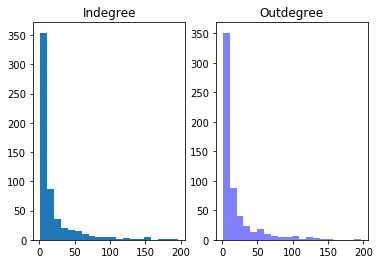

In [11]:
### the sparsity of indegree
os.chdir("/Users/zhuwu/Dropbox/Wu_Yang/data/network_measures")
infile = "cite_flow_5_year_window_sic4.csv"
df = pd.read_csv(infile)
di = {"citing_sic_cd":"citing","cited_sic_cd":"cited"}
df = df.rename(columns = di)
data = df.loc[df.year == 2014]

indeg = data[data.out_flow > 0].groupby(by = ['citing'])['out_flow'].count().reset_index()
outdeg = data[data.out_flow > 0 ].groupby(by = ['cited'])['out_flow'].count().reset_index()

fig,(ax1,ax2) = plt.subplots(1,2)

x,y,z = ax1.hist(indeg.out_flow,bins = 20)
x,y,z = ax2.hist(outdeg.out_flow,bins = 20,color = 'blue',alpha = 0.5,linestyle = '--')
ax1.set_title("Indegree")
ax2.set_title("Outdegree")
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/figures/sparsity_at_sic4.png")

In [12]:
infile = "cite_flow_5_year_window_uspc.csv"
df = pd.read_csv(infile)
di = {"uspc_citing":"citing","uspc_cited":"cited"}
df.rename(columns = di,inplace = True)
data = df.loc[df.year == 2014]

/Users/zhuwu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2.3 Heatmap of the Citation Networks

In [13]:
os.chdir("/Users/zhuwu/Dropbox/Wu_Yang/data/network_measures")
infile = "cite_flow_5_year_window_sic.csv"
df = pd.read_csv(infile)
di = {"citing_sic_cd":"citing","cited_sic_cd":"cited"}
df = df.rename(columns = di)
data = df.loc[df.year == 2014]

### 2.3.1 Measure Citation Strength as the Fraction of Total Citations

In [14]:
def heatmap(data,within = True):
    
    """
    construct a citation heatmap to see the sparsity 
    
    """
    
    ### check whether we need to calculate the cites within sectors
    if within == False:
        data = data.loc[data.citing != data.cited]
        
    
    #data.loc[:,'log_out_flow'] = np.log(data.out_flow)/np.log(10)
    data.loc[:,'tot_flow'] = data.groupby(by = ['citing'])['out_flow'].transform('sum')
    
    ## normalize the sum row vector to one 
    data.loc[:,'value'] = data.out_flow.values/data.tot_flow.values
    #data['value'] = 10*data['value']
    ## transform to wide dataset
    data = data.pivot(index = "citing",columns = "cited",values = "value")
    data.fillna(value = 0,inplace = True)
    
    
    
    if within == True:
        ax = sns.heatmap(data,robust = True,center = 0.5)
        #ax = sns.heatmap(data,vmin = 0,vmax = 1,center = 0.7)
    
    if within == False:
        ax = sns.heatmap(data,robust = True,center = 0.5)
        #ax = sns.heatmap(data,vmin = 0,vmax = 1,center = 0.7)
    
    return ax


/Users/zhuwu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/zhuwu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


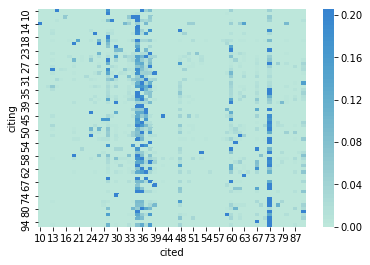

In [15]:
ax = heatmap(data,within = False)
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/figures/heatmap_sparsity_at_sic2_exclude_within_cites.png")

In [ ]:
ax = heatmap(data,within = True)
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/figures/heatmap_sparsity_at_sic2_include_within_cites.png")

### 2.3.2 Measure Citation Strength as Cites per Patent

#### 2.3.2.1 Construct the Citation Matrix, and Examine its Properties

In [16]:
os.chdir("/Users/zhuwu/Dropbox/Patent")

In [17]:
indus = pd.read_excel("/Users/zhuwu/Dropbox/Wu_Yang/data/industry_data/naics3_1947_2018_naics17.xlsx")
indus = indus.sort_values(by = ['naics3','year'])
indus.rename(columns = {'naics3':'naics'},inplace = True)

In [18]:
### define a method to read naics-to-naics cite data
def read_naics_to_naics(infile,indus = indus,diag = True):
    
    """
    diag: True - allow citation within the same sector, False - shut down the citation within the same sector
    indus: dataset - with naics code where the output share is available
    """
    
    df = pd.read_csv(infile)
    
    if infile == "naics3_to_naics3_via_companies.csv":
        
        cols = ['citing_naics','cited_naics','cites','no_of_pats','year']
        df = df[cols]
        df = df.rename(columns = {'citing_naics':'citing','cited_naics':'cited'})
        df['tot_cits'] = df.groupby(by = ['year','citing'])['cites'].transform('sum')
        #df['cij'] = df.cites.values/df.no_of_pats.values
        df['PWQij'] = df.cites.values/df.tot_cits.values
        df['cij'] = df['PWQij']
        
    elif infile == "naics3_uspc_naics3_W_matrix.csv":
        
        cols = ['naics_citing','naics_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'naics_citing':"citing",'naics_cited':'cited'})
        df['cij'] = df['PWQij']
    
    elif infile == "naics3_uspc_naics3_W_matrix_PQmethod_citation.csv":
        
        cols = ['naics_citing','naics_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'naics_citing':"citing",'naics_cited':'cited'})
        df['cij'] = df['PWQij']
        
    ### only keep industries with output share available, there are 2 3-digit industries missing output share
    df = pd.merge(left = df,right = indus,left_on = ['citing','year'],right_on = ['naics','year'],how = 'inner')
    df = df[['citing','cited','PWQij','year','cij']]
    df = pd.merge(left = df,right = indus,left_on = ['cited','year'],right_on =['naics','year'],how = 'inner')
    df = df[['citing','cited','PWQij','year','cij']]
    df['tot_cij'] = df.groupby(by = ['year','citing'])['cij'].transform('sum')
    df['cij'] = df['cij']/df['tot_cij']
    
    if diag == False:
        
        mask = (df['citing']!=df['cited'])
        df = df[mask]
        df['tot_cij'] = df.groupby(by = ['year','citing'])['cij'].transform('sum')
        df['cij'] = df['cij']/df['tot_cij']
        
    
        
    return df

def read_sic_to_sic(infile,diag = True):
    
    """
    diag: True - allow citation within the same sector, False - shut down the citation within the same sector
    
    """
    
    df = pd.read_csv(infile)
    
    if infile == "sic3_to_sic3_via_companies.csv":
        
        cols = ['citing_siccd','cited_siccd','cites','no_of_pats','year']
        df = df[cols]
        df = df.rename(columns = {'citing_siccd':'citing','cited_siccd':'cited'})
        df['tot_cits'] = df.groupby(by = ['year','citing'])['cites'].transform('sum')
        #df['cij'] = df.cites.values/df.no_of_pats.values
        df['cij'] = df.cites.values/df.tot_cits.values
        
    elif infile == "sic3_uspc_sic3_W_matrix.csv":
        
        cols = ['siccd_citing','siccd_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'siccd_citing':"citing",'siccd_cited':'cited'})
        df['cij'] = df['PWQij']
        
    elif infile == "sic3_uspc_sic3_W_matrix_PQmethod_citation.csv":
        
        cols = ['siccd_citing','siccd_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'siccd_citing':'citing','siccd_cited':'cited'})
        df['cij'] = df['PWQij']
        
    if diag == False:
        
        mask = (df['citing']!=df['cited'])
        df = df[mask]
        df['tot_cij'] = df.groupby(by = ['year','citing'])['cij'].transform('sum')
        df['cij'] = df['cij']/df['tot_cij']
             
           
    return df


In [19]:
class Citation_Matrix(object):
    
    
    """
    Transform the dataframe citing-cited data into Citation Matrix, and Explore its Properties
    """
    
    def __init__(self,data):
        
        """
        
        data: data is the annual citing-cited data 
        
        """
        
        self.data = data
        
    def index_industry(self):
        
        """
        
        index each industry starts with zero and ends with the number of industries - 1
        
        return - index-industry concordance
        
        """
        
        data = self.data
        
        node = set(data.citing).union(data.cited)
        node = pd.DataFrame(node,columns = ['id'])
        node = node.sort_values(by = ['id']).reset_index()['id'].reset_index()
        
        return node
    
    def cross_node(self):
        
        """
        input - the index of the nodes
        output - the node x node matrix 
        
        """
        
        node = self.index_industry()
        node['key'] = 1
        
        node = pd.merge(left = node,right = node,left_on = 'key',right_on = ['key'],how = 'inner')
        node = node.rename(columns = {'index_x':'index_citing',
                              'index_y':'index_cited','id_x':'id_citing','id_y':'id_cited'})
        
        return node
    
    def cross_node_data(self):
        
        """
        cross the node, also match the data about citation
        output - a dataframe include: index_citing, index_cited, no_of_pats, cites
    
        """
        
        node = self.cross_node()
        data = self.data
        
        dt = pd.merge(left = node, right = data, 
              left_on = ['id_citing','id_cited'],right_on = ['citing','cited'],how = 'left')
        
        #dt = dt[['index_citing','index_cited','cites','no_of_pats','id_citing','id_cited']]
        cols = ['index_citing','index_cited','cij','id_citing','id_cited']
        dt = dt[cols]
    
        return dt
    
    def transform(self):
        
        """
        
        transform the dataframe dataset to a numpy array
        
        """
        
        dt = self.cross_node_data()
        
        #dt['cij'] = dt['cites']/dt['no_of_pats']
        dt['cij'] = dt['cij'].fillna(0)
        
        cols = ['index_citing','index_cited','cij']
        dt = dt[cols]
        dt = dt.sort_values(by = ['index_citing','index_cited'])
        dt = dt.pivot(index = 'index_citing',columns = 'index_cited',values = 'cij')
        
        m = dt.to_numpy()
        
        return dt,m
    
    def sparsity_eigenvalue(self):
        
        """
        Purpose - visualize the distribution of the eigenvalues to see if 
        
        the eigenvalues drop significantly and take sparse pattern
        
        """
        
        dt,m = self.transform()
        
        ## transpose the citation matrix 
        m = m.T
        ## calculate the eigenvalue
        w,V = linalg.eig(m)
        
        ## sort the eigenvalues and eigenvectors in descending
        index = w.argsort(axis = -1,kind = 'quicksort')[::-1]
        w = w[index]
        V = V[:,index]
        
        ## visualize the histogram distribution
        fig,ax = plt.subplots(nrows = 1,ncols = 2,sharey = True,figsize = (8,6))
        
        ## plot the real and imaginary parts separately
        ax0 = ax[0]
        ax0.hist(np.real(w),bins = 10)
        
        ax1 = ax[1]
        ax1.hist(10**5*np.imag(w),bins = 10)
        
        ax0.set_ylabel("Frequency")
        ax0.set_xlabel("Real Part (unit = $10^0$)")
        ax1.set_xlabel("Imaginary Part (unit = $10^{-5}$)")
        
        #fig.suptitle("Eigenvalues of Citation Matrix")
        
        return fig
    
    def eigenvalue(self):
        
        """
        Purpose - visualize the distribution of the eigenvalues to see if 
        
        the eigenvalues drop significantly and take sparse pattern
        
        """
        
        dt,m = self.transform()
        
        ## transpose the citation matrix 
        m = m.T
        ## calculate the eigenvalue
        w,V = linalg.eig(m)
        
        index = w.argsort(axis = -1,kind = 'quicksort')[::-1]
        w = w[index]
        V = V[:,index]
        
        return w
    
    def eigenvector(self):
        
        """
        calculate the eigenvector correspond to all eigenvalues
        """
        
        dt,m = self.transform()
        
        m = m.T
        w,V = linalg.eig(m)
        
        ### sort the eigenvalues and eigenvectors in descending
        index = w.argsort(axis = -1,kind = 'quicksort')[::-1]
        w = w[index]
        V = V[:,index]
        
        for i in range(len(index)):
            
            if np.sum(np.real(V[:,i])) < 0:
                V[:,i] = - V[:,i]
    
        
        data = pd.DataFrame(np.real(V))
        
        
        data.columns = ['vec'+str(i) for i in data.columns]
        
        ### match back to the industry code
        data = data.reset_index()
        
        index = self.index_industry()
        
        data = pd.merge(left = index,right = data,left_on = ['index'],right_on = ['index'],how = 'inner')
        
        return data

##### 1. Visualize the distributions of eigenvalues
 - we decompose the eigenvalue into real and imaginary parts
 - check whether the imaginary commponent should be a main concern

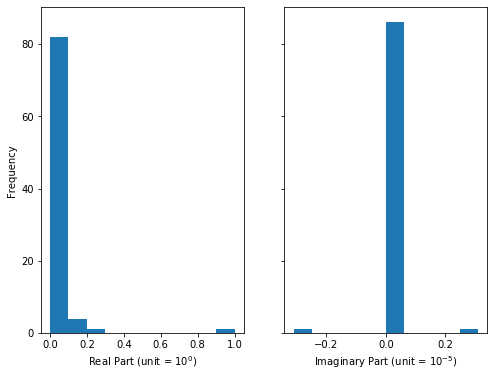

In [20]:
### Visualize the eigenvalue distribution in 2014

infile = "naics3_uspc_naics3_W_matrix.csv"
df = read_naics_to_naics(infile,diag = True)
data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)

fig = cit.sparsity_eigenvalue()
figname = "/Users/zhuwu/Dropbox/Wu_Yang/model/figures/"+"sparsity_eigenvalue_naics_uspc_naics_network"+".png"
fig.savefig(figname) 

In [37]:
#### save the eigenvectors associated with the values 

infile = "naics3_uspc_naics3_W_matrix.csv"
df = read_naics_to_naics(infile,diag = True)


data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)
eigenvec = cit.eigenvector()
eigenvec['year'] = 2014

for year in range(2013,1951,-1):
    data = df.loc[df.year == year]
    cit = Citation_Matrix(data)
    dt = cit.eigenvector()    
    dt['year'] = year
    eigenvec = eigenvec.append(dt,sort = False)
filename = "/Users/zhuwu/Dropbox/Wu_Yang/model/eigenvectors_1951_2014_naics_to_naics_W_matrix" + ".csv"
eigenvec.to_csv(filename)


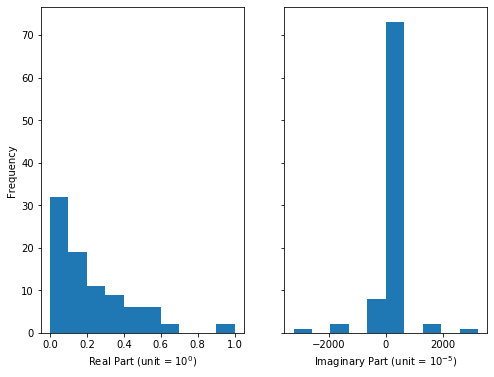

In [21]:
### Visualize the eigenvalue distribution based on firm-to-firm direct citation
infile = "naics3_to_naics3_via_companies.csv"
df = read_naics_to_naics(infile,diag = True)

data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)

fig = cit.sparsity_eigenvalue()
figname = "/Users/zhuwu/Dropbox/Wu_Yang/model/figures/"+"sparsity_eigenvalue_naics_to_naics_via_companies"+".png"
fig.savefig(figname) 

In [ ]:
### Visualize the eigenvalue distribution based on firm-to-firm direct citation
infile = "naics3_to_naics3_via_companies.csv"
df = read_naics_to_naics(infile,diag = False)

data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)

fig = cit.sparsity_eigenvalue()
figname = "/Users/zhuwu/Dropbox/Wu_Yang/model/figures/"+"sparsity_eigenvalue_naics_to_naics_via_companies_exclue_diag"+".png"
fig.savefig(figname) 


In [ ]:
### Visualize the eigenvalue distribution - both the P and Q matrix are estimated using citation distribution
infile = "naics3_uspc_naics3_W_matrix_PQmethod_citation.csv"
df = read_naics_to_naics(infile,diag = True)
data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)
fig = cit.sparsity_eigenvalue()

In [ ]:
infile = "sic3_uspc_sic3_W_matrix_PQmethod_citation.csv"
df = read_sic_to_sic(infile,diag = True)
data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)
fig = cit.sparsity_eigenvalue()

In [ ]:
infile = "sic3_uspc_sic3_W_matrix.csv"
df = read_sic_to_sic(infile,diag = True)
data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)
fig = cit.sparsity_eigenvalue()

In [ ]:
infile = "sic3_to_sic3_via_companies.csv"
df = read_sic_to_sic(infile,diag = True)
data = df.loc[df.year == 2014]
cit = Citation_Matrix(data)
fig = cit.sparsity_eigenvalue()

### 2.3.3. Calculate the Output Share and Concentration Index
The concentration index is defined as 
$$N^s_t = - \sum_j s_{jt}\log(s_{jt})$$
where $s_{jt}$ is the share of sector $j$ in gross at period $t$

In [172]:
class Output_Share():
    
    """
    
    define Class Output_Share to calculate the share of each sector 
    
    """
    
    def __init__(self,infile,by_cols = ['year'],by_vars = ['naics3out'],industry = "naics3"):
        
        self.infile = infile ## infile is the file saving the gross output
        self.by_cols = by_cols ## groupby 
        self.by_vars = by_vars ## the variabel needs to be aggregated
        self.industry = industry ##define the aggregate level of industry
    
    def cal_output_share(self):
    
        """
        Calculate the share distribution across sectors 
        
        """
    
        infile = self.infile
        by_cols = self.by_cols
        by_vars = self.by_vars
    
        ### read the date
        data = pd.read_excel(infile)
    
        ### 
        for x in by_vars:
            data['tot_'+x] = data.groupby(by = by_cols)[x].transform('sum')
            data[x+"_share"] = data[x]/data['tot_'+x]
     
        return data

    def rename_cols(self):
    
        """
        rename the columns for general treatment
        """
        
        industry = self.industry
        data = self.cal_output_share()
        
        share = self.by_vars[0]+"_share"
        
        if industry == "naics3":
            data = data.rename(columns = {'naics3':'naics',share:"share"})
        
        if industry == "naics2":
            data = data.rename(columns = {"naics2":"naics2",share:"share"})
            
        if industry == "naics3" or industry == "naics2":
            cols = ['year','naics','share']
            data = data[cols]
        return data 
    
    def transform(self):
        
        """
        transform the data to standard data 
        """
        return self.rename_cols()
    
    def cal_concentration(self):
        
        """
        Calculate the Concentration, the concentration is defined as 
        
        $-\sum_j s_j \log(s_j)$

        """
        data = self.transform()
        data['log_share'] = np.log(data.share.values)
        data['share_log_share'] = -data.share.values*data.log_share.values
        
        data = data.groupby(by = ['year'])['share_log_share'].sum().reset_index()
        
        return data
    
    def conc_effect(self):
        
        """
        calculate the growth effect from change in concentration
        """
        
        data = self.cal_concentration()
        
        data['delta_conc'] = (data['share_log_share'] - data['share_log_share'].shift(1))*100
        
        
        fig,ax = plt.subplots(figsize = (8,6))
        
        ax.plot(data.year,data.delta_conc,color = 'blue')
        ax.axhline(y = 0,linestyle = '--')
        #ax.plot(range(1947,2020),[0]*len(range(1947,2020)),linestyle = 'dashed')
        ax.set_xticks(range(1947,2018,5))
        ax.set_xlabel("Year")
        ax.set_ylabel("Concentration Effect")
        
        ax = shadow_adverse_shocks(ax,x_lim = [1946,2018])
        
        figname = "/Users/zhuwu/Dropbox/Wu_Yang/model/figures/" + "concentration_effect.png"
        
        
        plt.savefig(figname)

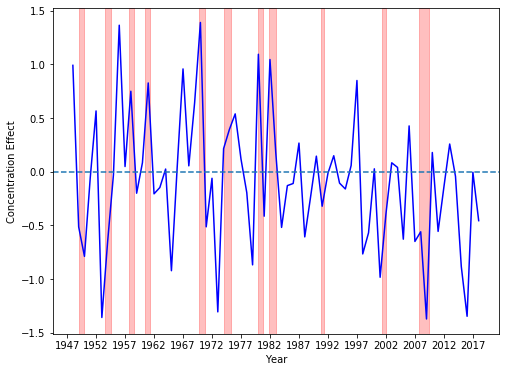

In [173]:
#### Calculate the output share
infile = "/Users/zhuwu/Dropbox/Wu_Yang/data/industry_data/naics3_1947_2018_naics17.xlsx"
output = Output_Share(infile,by_cols = ['year'],by_vars = ['naics3out'],industry = "naics3")
data2 = output.transform()
output.conc_effect()

In [139]:
#### Import the annual Growth of Real GDP
def read_gdp_annual_growth():
    
    infile = "/Users/zhuwu/Dropbox/Wu_Yang/data/gdp/GDP_growth_annual_1930_2018.xls"
    df = pd.read_excel(infile,skiprows = 10)
    df.rename(columns = {'observation_date':'date','A191RL1A225NBEA':'growth'},inplace = True)
    df['year'] = df.date.dt.year 
    
    df = df[['growth','year']]
    
    ### detrend the growth: simply minus the average growth
    df['growth'] = df['growth'] - np.mean(df['growth'].values)
    
    return df



In [140]:
df = read_gdp_annual_growth()
conc = output.cal_concentration()
conc['delta_conc'] = (conc['share_log_share'] - conc['share_log_share'].shift(1))*100
df = pd.merge(left = df, right = conc,left_on = ['year'],right_on = ['year'],how = 'inner')


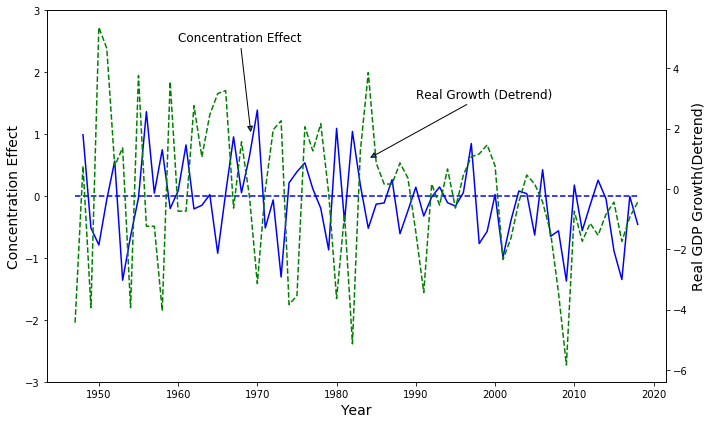

In [141]:
### Visualize the Growth and Concentration Effect

fig,ax1 = plt.subplots(figsize = (10,6))

ax1.set_xlabel("Year",fontsize = 14)
ax1.set_ylabel("Concentration Effect",fontsize = 14)
ax1.plot(df.year,df.delta_conc,color = 'blue',label = "Concentration Effect")
ax1.plot(df.year,[0]*len(df.year),color = 'blue',linestyle = '--')
ax1.set_yticks([-3,-2,-1,0,1,2,3])

ax2 = ax1.twinx()
ax2.set_ylabel("Real GDP Growth(Detrend)",fontsize = 14)
ax2.plot(df.year,df.growth,color = 'green',linestyle = '--',label = "Real GDP Growth (Detrend)")

### Add annotation 
plot_arrowsl = {'arrowstyle':'-|>','connectionstyle':'arc3,rad = -0.2'}
plot_arrowsr = {'arrowstyle':'-|>','connectionstyle':'arc3,rad = 0.0'}

ax1.annotate("Concentration Effect",xy = (1969.2,1),xytext = (1960,2.5),
            arrowprops = plot_arrowsr,fontsize = '12')
ax2.annotate("Real Growth (Detrend)",xy = (1984,1),xytext = (1990,3),
            arrowprops = plot_arrowsr,fontsize = '12')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/figures/" + "concentration_effect_vs_growth.png")

In [29]:
conc = output.cal_concentration()
filename = "/Users/zhuwu/Dropbox/Wu_Yang/model/concentration_1947_2017.csv"
outfile = conc.to_csv(filename)

### 2.3.4 Check How Eigenvector of Citation Networks Span the Production Centrailty

We examine whether the technology centrality is coincidence with the production centrality

#### 1. Estimate the sparisity of eigenvaluce over time

#### 2. Estimate the variance of the share spanned by various eigen values


In [30]:
def eigenvalue_decomposition(share_infile,net_infile,year = 2014):
    
    """
    The purpose of this function is to calculate the fraction of the 1st, 5st and 10th eigenvalue of the citation 
    
    networks, to see how the sparisity of eigenvalue dynamics
    
    input:
    
    share_infile - the file documented the output
    net_infile - the file contain the naics3-to-naics3 citation matrix information

    """
    
    ### Call the class Output_Share to calculate the share
    
    output = Output_Share(share_infile,by_cols = ['year'],by_vars = ['naics3out'],industry = "naics3")
    data2 = output.transform()

    indus = data2 ## keep naics code without missing output share
    
    ### Calculate the eigenvector of the citation matrix
    df = read_naics_to_naics(net_infile,indus = indus)
    
    
    ## For the years before 1952,there is no citation information, we approximatly assume 
    ### the knowledge diffusion networks is stable and use the knowledge diffusion networks in 1952 to proxy for it
    ### We need to document the persistence of the network structure empirically, empirically, it is true
    
    #### For sample beyond 2014, we also use the knowledge diffusion matrix at 2014 to proxy for it
    year_rep = year
    
    if year <= 1952:
        year_rep = 1952
    
    if year > 2014:
        year_rep = 2014
        
    data = df.loc[df.year == year_rep]
    cit = Citation_Matrix(data)
    eigval = cit.eigenvalue()
    
    ## calculate the norm of the 1st 5th and 10th 
    var_t = sum(np.absolute(eigval))
    var_t5 = sum(np.absolute(eigval[:5]))
    var_t10 = sum(np.absolute(eigval[:10]))
    var_t1 = sum(np.absolute(eigval[:1]))

    var = {'var_t':var_t,'var_t1':var_t1,'var_t5':var_t5,'var_t10':var_t10,'year':year}

    data = pd.DataFrame([var])
    
    ### export the eigvalues 
    
    eigval = pd.DataFrame(eigval).T
    eigval['year'] = year
    
    return data,eigval

In [31]:
share_infile = infile = "/Users/zhuwu/Dropbox/Wu_Yang/data/industry_data/naics3_1947_2018_naics17.xlsx"
net_infile = "naics3_uspc_naics3_W_matrix.csv"
data,dt= eigenvalue_decomposition(share_infile = share_infile,net_infile = net_infile,year = 2017)
for year in range(2016,1926,-1):
    print(year)
    data = data.append( eigenvalue_decomposition(share_infile = share_infile,
                                                 net_infile = net_infile,year = year)[0],sort = True)
    dt = dt.append( eigenvalue_decomposition(share_infile = share_infile,
                                                 net_infile = net_infile,year = year)[1],sort = True)

2016
2015
2014
2013
2012
2011
2010
2009
2008
2007
2006
2005
2004
2003
2002
2001
2000
1999
1998
1997
1996
1995
1994
1993
1992
1991
1990
1989
1988
1987
1986
1985
1984
1983
1982
1981
1980
1979
1978
1977
1976
1975
1974
1973
1972
1971
1970
1969
1968
1967
1966
1965
1964
1963
1962
1961
1960
1959
1958
1957
1956
1955
1954
1953
1952
1951
1950
1949
1948
1947
1946
1945
1944
1943
1942
1941
1940
1939
1938
1937
1936
1935
1934
1933
1932
1931
1930
1929
1928
1927


In [ ]:
for i in range(88):
    dt.rename(columns = {i:'eigval'+str(i)},inplace = True)

In [ ]:
dt.to_csv("/Users/zhuwu/Dropbox/Wu_Yang/model/eigenvalues_citation_matrix_1927_2017.csv")

In [ ]:
fig,ax = plt.subplots(figsize = (8,6))
data['ratio1'] = data['var_t1']/data['var_t']
data['ratio5'] = data['var_t5']/data['var_t']
data['ratio10'] = data['var_t10']/data['var_t']
data = data[((data.year >= 1951)&(data.year<=2014))]
plt.plot(data.year,data.ratio1,color = 'black',linestyle = '--')
plt.plot(data.year,data.ratio5,color = 'blue',linestyle = '-.')
plt.plot(data.year,data.ratio10,color = 'red')
plt.legend(['1st eigenvalue','Top-5 eigenvalues','Top-10 eigenvalues'])
figname = "/Users/zhuwu/Dropbox/Wu_Yang/model/" + "eigenvalues_over_years.png"
plt.savefig(figname)    

#### Examine how the sharevector is spanned by tech eigenvectors

In [ ]:
import statsmodels.formula.api as smf
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [ ]:
#### Calculate the output share
def inner_product(share_file,net_file,year):
    
    '''
    The purpose of this function is to calculate the inner product between sale-share and eigenvector of citation 
    
    networks 
    
    '''
    
    ### calculate the output share 
    
    year_cite = year
    year_indus = year
    
    if year <= 1952:     
        year_cite = 1952
    elif year > 2014:
        year_cite = 2014
    
    if year <= 1947:
        year_indus = 1947

    output = Output_Share(share_file,by_cols = ['year'],by_vars = ['naics3out'],industry = "naics3")
    data2 = output.transform()
    data2 = data2.loc[data2.year == year_indus]
    
    indus = data2 ## keep naics code without missing output share
    indus['year'] = year_cite ## to adjust the year so that it can match the year in citation-matrix

    #indus = pd.DataFrame(data2['naics']) 
    ### Calculate the eigenvector of the citation matrix
    df = read_naics_to_naics(net_file,indus = indus)
    data = df.loc[df.year == year_cite]
    cit = Citation_Matrix(data)

    eigvec = cit.eigenvector()
    eigvec = eigvec.sort_values(by = ['vec0'],ascending = False)

    dt = pd.merge(left = eigvec,right = data2,left_on = ['id'],right_on = ['naics'],how = 'inner',indicator = True)

    cols = [dt.columns[-2]] + [col for col in dt if col!=dt.columns[-2]]
    dt = dt[cols]
    
    ### We also visualize the inner product for the network 2014
    if year == 2014:
        share_vec = []
        for i in range(86):
            share_vec.append(np.abs(sum(dt['share'].values*dt['vec'+ str(i)].values)))

        fig,ax = plt.subplots(figsize = (8,6))
        plt.plot(range(1,87),share_vec,color = 'blue')
        ax.set_xlabel("Eigenvalues $\lambda_i$",fontsize = 16)
        ax.set_ylabel(r'$\boldsymbol{{v}}_i^T\boldsymbol{s}$',fontsize = 16)
        #ax.set_title("Inner Product of Eigenvectors and Sale-Share")
        plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/figures/inner_product_share_techvec_distribution_2014.png")
        
    share_vec = {}
    for i in range(80):
        share_vec[i] = sum(dt['share'].values*dt['vec'+str(i)].values)
        
    share_vec['year'] = year
    
    ### Calculate the correlation coefficient
    cols = ['share','vec0','vec1','vec2','vec3','vec4']
    coeff = dt[cols].corr(method = 'pearson')['share']
    coeff['year'] = year
    
    return share_vec,coeff

In [ ]:
share_file = "/Users/zhuwu/Dropbox/Wu_Yang/data/industry_data/naics3_1947_2018_naics17.xlsx"
net_file = "naics3_uspc_naics3_W_matrix.csv"

share_vec,coeff = inner_product(share_file,net_file,2017)
data1 = pd.DataFrame(share_vec,index = [0])
data2 = pd.DataFrame(coeff).T
for year in range(2016,1926,-1):
    share_vec, coeff = inner_product(share_file,net_file,year)
    data1 = data1.append(pd.DataFrame(share_vec,index = [0]))
    data2 = data2.append(pd.DataFrame(coeff).T)
for i in range(80):
    data1.rename(columns = {i:'vec_share'+str(i)},inplace = True)    

In [ ]:
data1.to_csv("/Users/zhuwu/Dropbox/Wu_Yang/model/inner_product_share_techvec_1927_2017.csv")

In [ ]:
#### Visualize the dynamics of the $s'v_i$ over years
fig,ax = plt.subplots(figsize = (10,6))

data1 = data1[data1.year >= 1947]
plt.plot(data1.year,np.abs(data1['vec_share0'].values),color = 'blue',linestyle = '-')
plt.plot(data1.year,np.abs(data1['vec_share1'].values),color = 'blue',linestyle = '--')
plt.plot(data1.year,np.abs(data1['vec_share2'].values),color = 'black',linestyle = '-')
plt.plot(data1.year,np.abs(data1['vec_share3'].values),color = 'black',linestyle = '--')
plt.plot(data1.year,np.abs(data1['vec_share4'].values),color = 'green',linestyle = '-')

ax.legend([r'$(\boldsymbol{s},\boldsymbol{v}_1)$',r'$(\boldsymbol{s},\boldsymbol{v}_2)$',
           r'$(\boldsymbol{s},\boldsymbol{v}_3)$',r'$(\boldsymbol{s},\boldsymbol{v}_4)$',
           r'$(\boldsymbol{s},\boldsymbol{v}_5)$'])
ax.set_xlabel('Year',fontsize = 16)
ax.set_ylabel(r"$(\boldsymbol{s},\boldsymbol{v}_i)$",fontsize = 16)
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/inner_product_share_techvec_over_years.png",fontsize = 20)

In [ ]:
#### Visualize the dynamics of the $coeff(s,v_i)$ over years
fig,ax = plt.subplots(figsize = (10,6))

data2 = data2[data2.year >= 1947]
plt.plot(data2.year,np.abs(data2['vec0'].values),color = 'blue',linestyle = '-')
plt.plot(data2.year,np.abs(data2['vec1'].values),color = 'blue',linestyle = '--')
plt.plot(data2.year,np.abs(data2['vec2'].values),color = 'black',linestyle = '-')
plt.plot(data2.year,np.abs(data2['vec3'].values),color = 'black',linestyle = '--')
plt.plot(data2.year,np.abs(data2['vec4'].values),color = 'green',linestyle = '-')

ax.legend(['$coeff(s,v_1)$','$coeff(s,v_2)$','$coeff(s,v_3)$','$coeff(s,v_4)$','$coeff(s,v_5)$'])
ax.set_xlabel('Year',fontsize = 16)
ax.set_ylabel("$coeff(s,v_i)$",fontsize = 16)
plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/coeff_of_share_techvec_over_years.png")

### 2.3.5 Measure the coincidence between eigenvector centrality and stock market shocks

In [ ]:
net_infile = "naics3_uspc_naics3_W_matrix.csv"

In [ ]:
#### Define a method to read naics-to-naics cite data 

def read_naics_to_naics_v2(infile,diag = True):
    
    """
    diag: Boolean variable, True - allow citation within the same sector,False 
    - shut down the citation within the sector
    
    net_infile: the file keep the citation matrix, default "naics3_uspc_naics3_W_matrix.csv"
    
    """
    
    df = pd.read_csv(infile)
    
    if infile == "naics3_to_naics3_via_companies.csv":
        
        cols = ['citing_naics','cited_naics','cites','no_of_pats','year']
        df = df[cols]
        df = df.rename(columns = {'citing_naics':'citing','cited_naics':'cited'})
        df['tot_cits'] = df.groupby(by = ['year','citing'])['cites'].transform('sum')
        #df['cij'] = df.cites.values/df.no_of_pats.values
        df['PWQij'] = df.cites.values/df.tot_cits.values
        df['cij'] = df['PWQij']
        
    elif infile == "naics3_uspc_naics3_W_matrix.csv":
        
        cols = ['naics_citing','naics_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'naics_citing':"citing",'naics_cited':'cited'})
        df['cij'] = df['PWQij']
    
    elif infile == "naics3_uspc_naics3_W_matrix_PQmethod_citation.csv":
        
        cols = ['naics_citing','naics_cited','PWQij','year']
        df = df[cols]
        df = df.rename(columns = {'naics_citing':"citing",'naics_cited':'cited'})
        df['cij'] = df['PWQij']
    
    if diag == False:
        
        mask = (df['citing']!=df['cited'])
        df = df[mask]
        df['tot_cij'] = df.groupby(by = ['year','citing'])['cij'].transform('sum')
        df['cij'] = df['cij']/df['tot_cij']
              
    return df

In [ ]:
df = read_naics_to_naics_v2(net_infile,diag = True)

In [ ]:
ret_infile = "/Users/zhuwu/Dropbox/Wu_Yang/stock return/yearly_return_naics3.csv"
data = pd.read_csv(ret_infile)
data = data[['naics3','year','ret']].rename(columns = {'naics3':'naics'})

In [ ]:
##### Calculate the inner product of the eigenvector centrality and the shocks proxied by stock return
def inner_product_eigvec_shock(df,data,year,shock_proxy = "ret"):
    
    """
    Purpose - construct the inner product of the eigenvector centrality and the proxies for shocks
    
    df: the citation dataset used to calculate the eigenvector centrality
    
    data: the data of shocks 
    
    """
    
    year_cite = year
    
    #### for the obervation beyond 2014 or 1952, we implictly assume the citation matrix are persistent and stable,
    #### we use the latest available network to proxy for it
    if year >=2015:
        year_cite = 2014
    elif year <= 1952:
        year_cite = 1952
    
    df1 = df[df.year == year_cite]
    data1 = data[data.year == year]
    
    if shock_proxy == "ret":
        data1.rename(columns = {'ret':'shock'},inplace = True)
    
    ### estimate the eigenvector centrality
    cit = Citation_Matrix(df1)
    eigvec = cit.eigenvector()
    indus_no = len(eigvec)
    eigvec = eigvec.sort_values(by = ['vec0'],ascending = False)

    dt = pd.merge(left = eigvec,right = data1,left_on = ['id'],right_on = ['naics'],how = 'inner',indicator = True)
    cols = [dt.columns[-2]] + [col for col in dt if col!=dt.columns[-2]]
    dt = dt[cols]

    if year == 2014:
        eigvec_shock = []
        for i in range(indus_no - 1):
            eigvec_shock.append(np.sum(dt['shock']*dt['vec'+str(i)]))
        fig,ax = plt.subplots(figsize = (8,6))
        plt.plot(range(len(eigvec_shock)),eigvec_shock,color = 'blue')
        ax.set_xlabel("Eigenvalues $\lambda_i$",fontsize = 16)
        ax.set_ylabel(r'$(\boldsymbol{v}_i,\boldsymbol{r}_t)$',fontsize = 16)
        plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/inner_product_techvec_yearly_ret_2014.png")  

    eigvec_shock = {}
    for i in range(80):
        eigvec_shock[i] = np.sum(dt['shock']*dt['vec'+str(i)])
    ### Calculate the inner product of the return and eigvec
    eigvec_shock['year'] = year
    dt = pd.DataFrame(eigvec_shock,index = [0])
    
    return dt

In [ ]:
dt = inner_product_eigvec_shock(df,data,2017)
for year in range(2016,1926,-1):
    dt = dt.append(inner_product_eigvec_shock(df,data,year))
for i in range(80):
    dt.rename(columns = {i:'vec_ret'+str(i)},inplace = True)


In [ ]:
dt.to_csv("/Users/zhuwu/Dropbox/Wu_Yang/model/inner_product_vi_ret_shock.csv")

In [ ]:
fig,ax = plt.subplots(figsize = (10,6))
plt.plot(dt['year'],dt['vec_ret0'],color = 'blue')
plt.plot(dt['year'],dt['vec_ret1'],color = 'blue',linestyle = '--')
plt.plot(dt['year'],dt['vec_ret2'],color = 'black',linestyle = '-')
plt.plot(dt['year'],dt['vec_ret3'],color = 'black',linestyle = '--')
plt.plot(dt['year'],dt['vec_ret4'],color = 'red',linestyle = '-')
plt.xticks(np.arange(1927,2018,5))
ax.set_xlabel("Year",fontsize = 16)
ax.set_ylabel(r"$(\boldsymbol{v}_i,\boldsymbol{r}_t)$",fontsize = 16)
ax.legend([r"$(\boldsymbol{v}_1,\boldsymbol{r}_t)$",r"$(\boldsymbol{v}_2,\boldsymbol{r}_t)$",
          r"$(\boldsymbol{v}_3,\boldsymbol{r}_t)$",r"$(\boldsymbol{v}_4,\boldsymbol{r}_t)$",
          r"$(\boldsymbol{v}_5,\boldsymbol{r}_t)$"])

plt.savefig("/Users/zhuwu/Dropbox/Wu_Yang/model/inner_product_techvec_yearly_ret_1927_2017.png")

## 4. Persistence of Shocks

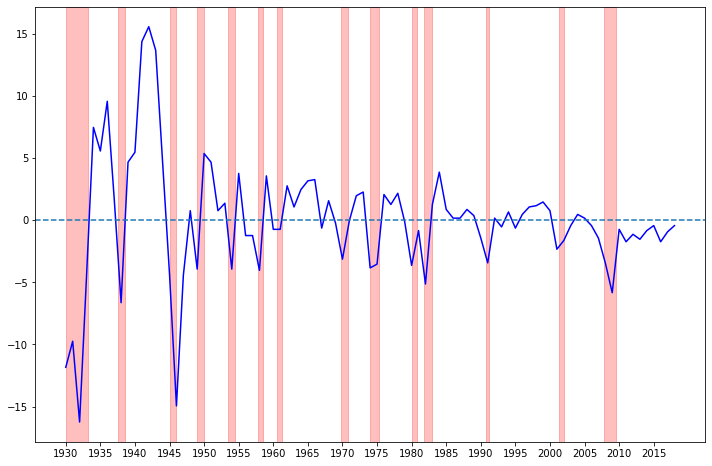

In [163]:
df = read_gdp_annual_growth()

def cal_cum_growth(df,window = 5):
    
    """
    Calculate the cummulative growth within the next window = 5 years
    
    """
    
    pass



import matplotlib.transforms as mtransforms

data = df[df.year >= 1929]
data.year = df.year 

fig,ax = plt.subplots(figsize = (12,8))

x_lim = [data.year.min(),data.year.max()]

ax.plot(data.year,data.growth,color = 'blue')
ax.set_xticks(range(x_lim[0],x_lim[1],5))
ax.axhline(y = 0,linestyle = '--')

"



shadow_adverse_shocks(ax,x_lim)


In [137]:
data.head()

growth  year
0 -11.837079  1930
1  -9.737079  1931
2 -16.237079  1932
3  -4.537079  1933
4   7.462921  1934

In [ ]:
# use data coordinates for the x-axis and the axes coordinates for the y-axis
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.axhline(theta, color='green', lw=2, alpha=0.5)
ax.axhline(-theta, color='red', lw=2, alpha=0.5)
ax.fill_between(x, 0, 1, where=y > theta,
                facecolor='green', alpha=0.5, transform=trans)
ax.fill_between(x, 0, 1, where=y < -theta,
                facecolor='red', alpha=0.5, transform=trans)


plt.show()


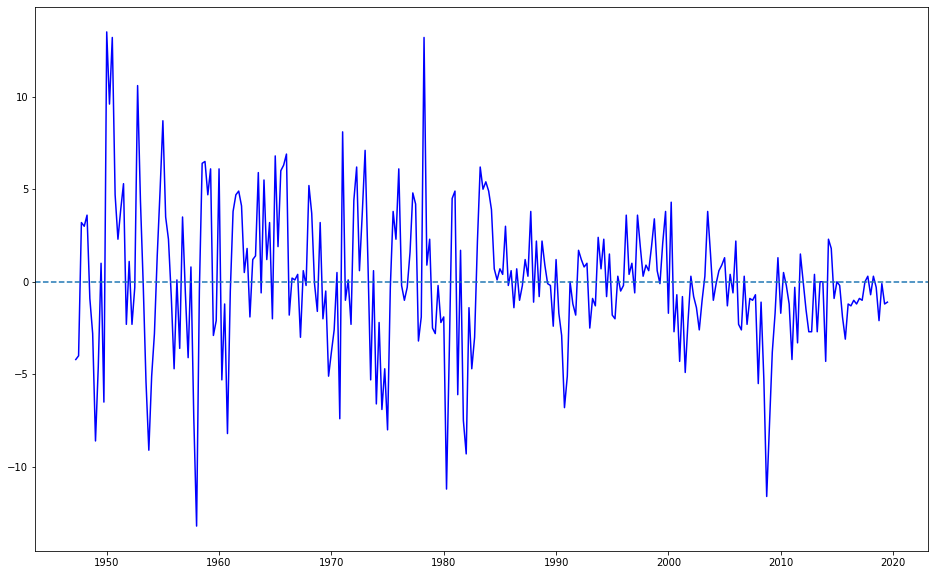

In [103]:
import pandas as pd
infile = "/Users/zhuwu/Dropbox/Wu_Yang/data/gdp/GDP_growth_quarter_1947_2019.xls"
df = pd.read_excel(infile,skiprows = 10)
df.rename(columns = {"observation_date":'date','A191RL1Q225SBEA':'growth'},inplace = True)

df.growth = df.growth - np.mean(df.growth)

plt.subplots(figsize = (16,10))
plt.plot(df.date,df.growth,color = 'blue')
plt.axhline(y = 0,linestyle = '--')

In [107]:
df

date     growth
0   1947-04-01  -4.208966
1   1947-07-01  -4.008966
2   1947-10-01   3.191034
3   1948-01-01   2.991034
4   1948-04-01   3.591034
5   1948-07-01  -0.908966
6   1948-10-01  -2.808966
7   1949-01-01  -8.608966
8   1949-04-01  -4.608966
9   1949-07-01   0.991034
10  1949-10-01  -6.508966
11  1950-01-01  13.491034
12  1950-04-01   9.591034
13  1950-07-01  13.191034
14  1950-10-01   4.691034
15  1951-01-01   2.291034
16  1951-04-01   3.891034
17  1951-07-01   5.291034
18  1951-10-01  -2.308966
19  1952-01-01   1.091034
20  1952-04-01  -2.308966
21  1952-07-01  -0.308966
22  1952-10-01  10.591034
23  1953-01-01   4.391034
24  1953-04-01  -0.108966
25  1953-07-01  -5.408966
26  1953-10-01  -9.108966
27  1954-01-01  -5.108966
28  1954-04-01  -2.808966
29  1954-07-01   1.391034
..         ...        ...
260 2012-04-01  -1.508966
261 2012-07-01  -2.708966
262 2012-10-01  -2.708966
263 2013-01-01   0.391034
264 2013-04-01  -2.708966
265 2013-07-01  -0.008966
266 2013-10-01  -0.008966
267 2014-01-01  -4.308966
268 2014-04-01   2.291034
269 2014-07-01   1.791034
270 2014-10-01  -0.908966
271 2015-01-01  -0.008966
272 2015-04-01  -0.208966
273 2015-07-01  -1.908966
274 2015-10-01  -3.108966
275 2016-01-01  -1.208966
276 2016-04-01  -1.308966
277 2016-07-01  -1.008966
278 2016-10-01  -1.208966
279 2017-01-01  -0.908966
280 2017-04-01  -1.008966
281 2017-07-01  -0.008966
282 2017-10-01   0.291034
283 2018-01-01  -0.708966
284 2018-04-01   0.291034
285 2018-07-01  -0.308966
286 2018-10-01  -2.108966
287 2019-01-01  -0.108966
288 2019-04-01  -1.208966
289 2019-07-01  -1.108966

[290 rows x 2 columns]

In [63]:
np.mean(df['growth'][:5])

-6.9770786516853915

In [67]:
g = {}
i = 0
for year,growth in zip(df['year'],df['growth']):
    
    g[year] = np.mean(df['growth'][i:i+5])
    i += 1

In [68]:
g

{1929: -6.9770786516853915,
 1930: -3.497078651685393,
 1931: 0.3629213483146076,
 1932: 3.9629213483146075,
 1933: 3.542921348314607,
 1934: 2.982921348314607,
 1935: 2.9629213483146075,
 1936: 3.9229213483146075,
 1937: 6.682921348314608,
 1938: 10.742921348314606,
 1939: 10.742921348314608,
 1940: 8.782921348314606,
 1941: 2.922921348314607,
 1942: -1.0770786516853925,
 1943: -3.657078651685393,
 1944: -5.377078651685393,
 1945: -3.4370786516853933,
 1946: 0.482921348314607,
 1947: 1.5229213483146071,
 1948: 1.6429213483146072,
 1949: 1.6429213483146072,
 1950: 1.3229213483146072,
 1951: 0.14292134831460715,
 1952: -0.2570786516853928,
 1953: -1.337078651685393,
 1954: 0.16292134831460725,
 1955: -0.7370786516853927,
 1956: -0.6370786516853926,
 1957: 0.16292134831460725,
 1958: 1.1829213483146073,
 1959: 0.9629213483146073,
 1960: 1.742921348314607,
 1961: 2.542921348314607,
 1962: 1.8629213483146074,
 1963: 1.9629213483146075,
 1964: 1.4229213483146073,
 1965: 0.16292134831460733,